## Create MAG accumulation curve
- How many new genomes do we assemble each metaG?
- Both strain and species wise
- Do we saturate the curve?

In [47]:
# import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# open clustering info
df = pd.read_csv('../data/Cdb_drep99.csv')

# keep from each genome SRA number
df['acc'] = df['genome'].str.split('_').str[1]
df['genome'] = df['genome'].str.split('.fasta').str[0]



In [3]:
# open clustering info
df2 = pd.read_csv('../data/Cdb_drep95.csv')

# keep from each genome SRA number
df2['acc'] = df['genome'].str.split('_').str[1]
df2['genome'] = df['genome'].str.split('.fasta').str[0]

In [4]:
df = df2

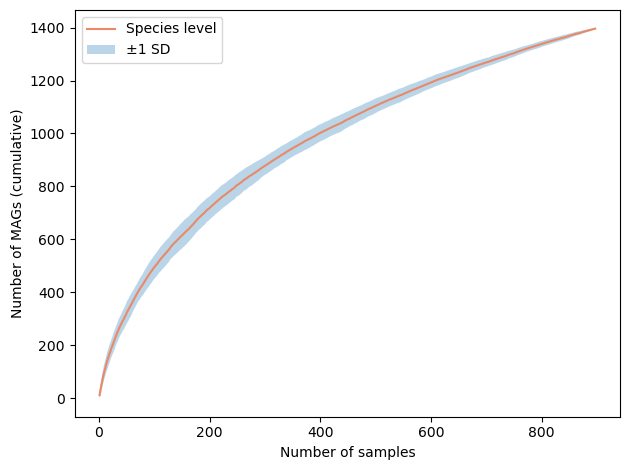

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def species_accumulation_from_long(df, sample_col='acc', species_col='secondary_cluster', n_permutations=100):
    samples = df[sample_col].unique()
    n_samples = len(samples)
    accumulation = np.zeros((n_permutations, n_samples))

    for i in range(n_permutations):
        np.random.seed(i)
        permuted_samples = np.random.permutation(samples)
        observed_species = set()
        for j, sample in enumerate(permuted_samples):
            species_in_sample = df[df[sample_col] == sample][species_col].unique()
            observed_species.update(species_in_sample)
            accumulation[i, j] = len(observed_species)

    mean_accumulation = accumulation.mean(axis=0)
    std_accumulation = accumulation.std(axis=0)
    return mean_accumulation, std_accumulation

# Example usage:
# df = your DataFrame with 'acc' and 'secondary_cluster' columns
mean, std = species_accumulation_from_long(df)

# Plot
x = np.arange(1, len(mean) + 1)
plt.plot(x, mean, label='Species level', color='#e98967ff')
plt.fill_between(x, mean - std, mean + std, alpha=0.3, label='±1 SD')
plt.xlabel('Number of samples')
plt.ylabel('Number of MAGs (cumulative)')
#plt.title('Species Accumulation Curve')
plt.legend()
plt.tight_layout()
#plt.savefig("../plots/250722_accumulation_curve_species.pdf", bbox_inches='tight')

plt.show()


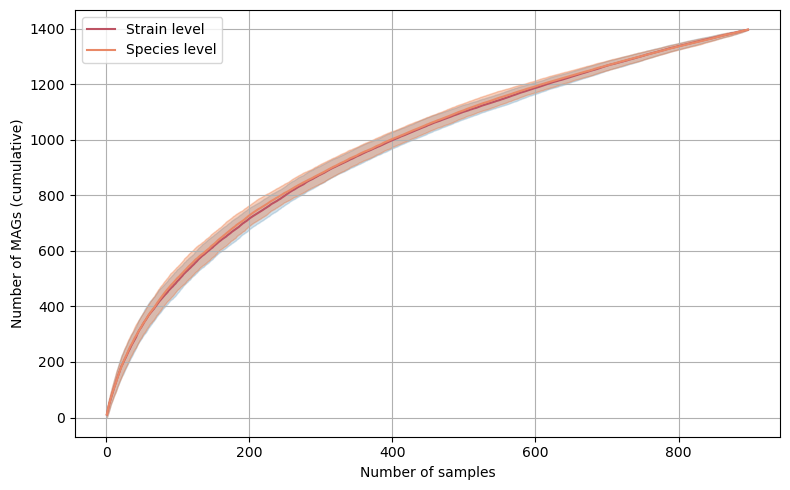

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def compute_accumulation(df, sample_col='acc', cluster_col='secondary_cluster', n_permutations=100):
    max_samples = df[sample_col].nunique()
    accumulated = np.zeros((n_permutations, max_samples))
    unique_accs = df[sample_col].unique()

    for i in range(n_permutations):
        seen = set()
        sample_order = np.random.permutation(unique_accs)
        counts = []
        for j, acc in enumerate(sample_order):
            clusters = df[df[sample_col] == acc][cluster_col].unique()
            seen.update(clusters)
            counts.append(len(seen))
        accumulated[i, :] = counts

    mean_curve = accumulated.mean(axis=0)
    std_curve = accumulated.std(axis=0)
    return mean_curve, std_curve

# Compute both curves
mean1, std1 = compute_accumulation(df)
mean2, std2 = compute_accumulation(df2)

# Shared x-axis range (trim to shortest if needed)
max_len = min(len(mean1), len(mean2))
x = np.arange(1, max_len + 1)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, mean1[:max_len], label='Strain level', color='#bd5363ff')
plt.fill_between(x, mean1[:max_len] - std1[:max_len], mean1[:max_len] + std1[:max_len], color='#669bbc', alpha=0.3)

plt.plot(x, mean2[:max_len], label='Species level', color='#e98967ff')
plt.fill_between(x, mean2[:max_len] - std2[:max_len], mean2[:max_len] + std2[:max_len], color='#eb6424', alpha=0.3)

plt.xlabel('Number of samples')
plt.ylabel('Number of MAGs (cumulative)')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig("../plots/250722_accumulation_curve_comparison_overlay.pdf", bbox_inches='tight')
plt.show()


##  Do we want an accumulation curve for samples?
- How many new species do we recover in each sample? Using all the MAGs, and GTDB? 
- Using all MAGs would be like using all genomes.. 

In [8]:
# open df with pres/abs
# df = pd.read_csv('../sourmash_gather/250721_gatherout.pig.csv', index_col=0)
df1 = pd.read_csv('../data/250830_gatherout.gtdbmags.species.pig.csv', index_col=0)
df1 = df1[df1.sum(axis=1) != 0]

# make bool
#df1 = df1.astype(bool) 
len(df1)

56739

In [14]:
df2 = pd.read_csv('../data/250813_gatherout.gtdb.species.pig.csv', index_col=0)
df2 = df2[df2.sum(axis=1) != 0]

# make bool
df2 = df2.astype(bool) 
len(df2)

55780

In [15]:
# set num perm
n_permutations = 100


In [20]:
#store accum species counts for eaach permutation
accumulated_counts = np.zeros((n_permutations, df.shape[1]))


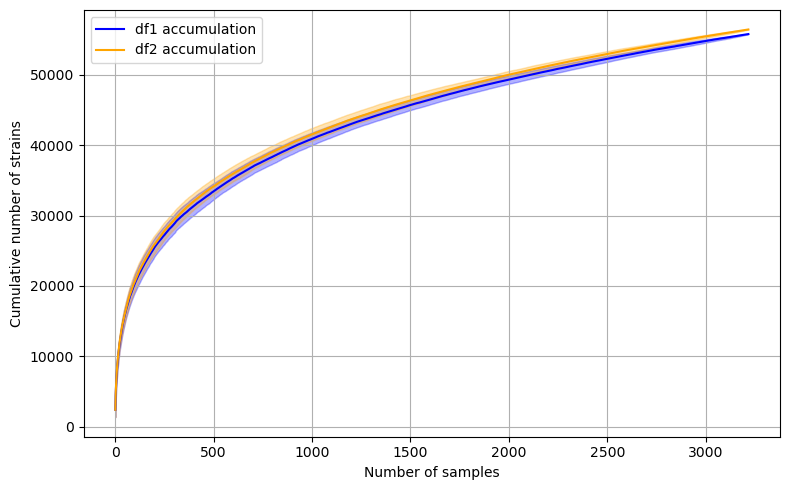

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def accumulation_curve(df, n_permutations=100):
    accumulated_counts = np.zeros((n_permutations, df.shape[1]))

    for i in range(n_permutations):
        permuted_cols = np.random.permutation(df.columns)
        seen_species = np.zeros(df.shape[0], dtype=bool)
        species_counts = []

        for col in permuted_cols:
            seen_species |= df[col].values
            species_counts.append(seen_species.sum())

        accumulated_counts[i, :] = species_counts

    mean_accum = accumulated_counts.mean(axis=0)
    std_accum = accumulated_counts.std(axis=0)
    return mean_accum, std_accum

# Compute accumulation curves for both dataframes
mean1, std1 = accumulation_curve(df1)
mean2, std2 = accumulation_curve(df2)

# Plot both curves
plt.figure(figsize=(8,5))

# df1 curve
plt.plot(range(1, df1.shape[1]+1), mean1, label='df1 accumulation', color='blue')
plt.fill_between(range(1, df1.shape[1]+1), mean1-std1, mean1+std1, color='blue', alpha=0.3)

# df2 curve
plt.plot(range(1, df2.shape[1]+1), mean2, label='df2 accumulation', color='orange')
plt.fill_between(range(1, df2.shape[1]+1), mean2-std2, mean2+std2, color='orange', alpha=0.3)

plt.xlabel("Number of samples")
plt.ylabel("Cumulative number of strains")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("../plots/250813_accumulation_curve_samples_comparison.pdf", bbox_inches='tight')
plt.show()


## Do taxonomy comparison: How many strains from each species, how many genomes, etc?

What I also would like to do is a sourmash compare on these genomes, to see if dereplication and kmers agree.
No we know that they agree cause we already looked at the overall loss of kmers when going to strains

## CURRENTLY NOT WORKING - what am i even trying to do?

In [18]:
# # now do tax stuff
# # open clustering info
# df = pd.read_csv('../data/Cdb_drep99.csv')

# # keep from each genome SRA number
# df['acc'] = df['genome'].str.split('_').str[1]
# df['genome'] = df['genome'].str.split('.fasta').str[0]
# # # open tax and merge
# dft = pd.read_csv('../data/250703_mag_taxonomy.tsv', sep='\t')
# dft.rename(columns={'user_genome':'genome'}, inplace=True)
# df = pd.merge(df,dft, on='genome')

# # now for top 10 most assembled species, plot number of strains. 
# top_species = df['species'].value_counts().head(10).index

# # Filter original DataFrame to only include those species
# top_species_df = df[df['species'].isin(top_species)]

In [19]:
# counts_df = top_species_df[['species', 'secondary_cluster']].value_counts().reset_index()

In [20]:
# counts_df.columns = ['species', 'cluster', 'cluster_size']
# counts_df = counts_df[['species', 'cluster_size']].value_counts().to_frame().reset_index()

In [42]:
# counts_df.head()

In [43]:
# counts_df['cluster_grouped'] = counts_df.apply(lambda row: 'Other' if row['count'] == 1 else row['cluster_size'], axis=1)


In [44]:
# grouped = counts_df.groupby(['species', 'cluster_grouped'], as_index=False)['count'].sum()

# # Step 3: Pivot for stacked bar plot
# pivot_df = grouped.pivot(index='species', columns='cluster_grouped', values='count').fillna(0)

# # Step 4: Assign colors: grey for 'Other', distinct colors for others
# import matplotlib.cm as cm
# cmap = cm.get_cmap('tab20')
# clusters = list(pivot_df.columns)
# colors = []
# for i, clust in enumerate(clusters):
#     if clust == 'Other':
#         colors.append('grey')
#     else:
#         colors.append(cmap(i % cmap.N))

# # Step 5: Plot
# ax = pivot_df.plot(kind='bar', stacked=True, color=colors, figsize=(10,6), legend=False)

# plt.ylabel('Count')
# #plt.title('Stacked bar plot grouping all count=1 per species into "Other" (grey)')
# plt.xticks(rotation=45, ha='right')
# #ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
# #plt.show()
# #plt.savefig('../plots/250528_count_strains.png')

In [45]:
# cluster_counts.groupby('species')['secondary_cluster'].nunique()


In [46]:
# cluster_counts = df['secondary_cluster'].value_counts()
# print((cluster_counts == 1).sum(), "clusters appear only once")

In [15]:
# cluster_freq = df.groupby('secondary_cluster')['acc'].nunique()
# cluster_freq.hist(bins=800)
# plt.xlabel('Number of samples a cluster appears in')
# plt.ylabel('Number of clusters')
# plt.title('Cluster distribution across samples')
# plt.show()


## Kmer accumulation curve
How many new kmers with each assembled MAG?

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load results
df = pd.read_csv("../data/new_kmers_mags.k31.csv")
 

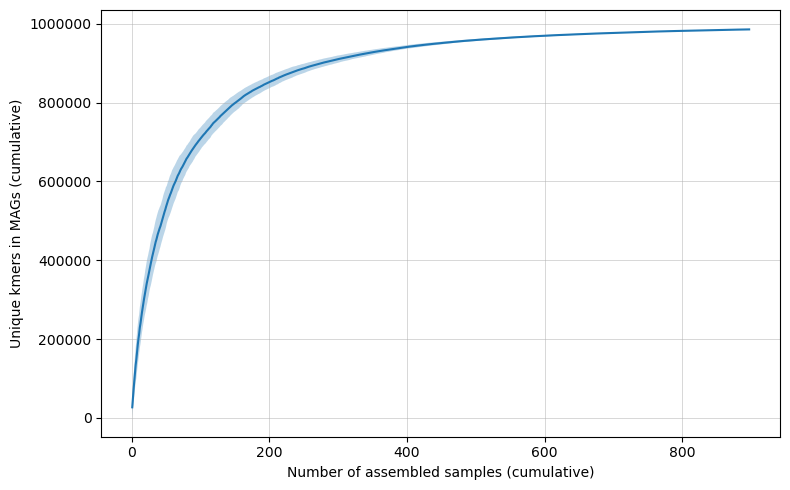

In [17]:
import pandas as pd
import matplotlib.pyplot as plt



# Make sure sorting is correct (just in case)
df = df.sort_values(by=["iteration", "position"])

# Group by iteration and calculate cumulative kmers per sample position
df["cumulative"] = df.groupby("iteration")["new_kmers"].cumsum()

# Calculate mean and std across iterations at each sample position
summary = df.groupby("position")["cumulative"].agg(["mean", "std"]).reset_index()

# Plot mean ± std accumulation curve
plt.figure(figsize=(8, 5))
plt.plot(summary["position"], summary["mean"], label="Mean cumulative k-mers")
plt.fill_between(summary["position"],
                 summary["mean"] - summary["std"],
                 summary["mean"] + summary["std"],
                 alpha=0.3, label="±1 std")

plt.xlabel("Number of assembled samples (cumulative)")
plt.ylabel("Unique kmers in MAGs (cumulative)")
plt.ticklabel_format(style='plain', axis='y')
#plt.yscale("log")
#plt.title("Accumulation Curve of Unique k-mers (Resampled)")
#plt.legend()
plt.grid(True, which="both", linestyle="-", linewidth=0.5, alpha=0.7)
plt.tight_layout()
#plt.show()
#plt.savefig('../plots/250808_accumcurve_kmers.k31.pdf')